<a href="https://colab.research.google.com/github/bassemr/DeepLearningAndGenerativeModelsCourse/blob/main/ex14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

First generative network that we are going to see.

In [11]:
# latent size
d = 4

# mean and std vectors from encoder
mu = torch.tensor([0.5, -0.2, 0.0, 1.0])
std = torch.tensor([0.1, 0.5, 0.2, 0.3])

# sample a vector z ~ N(mu, std)
epsilon = torch.randn(d)          # sample from N(0,1)
z = mu + std * epsilon            # reparameterization trick

print("Sampled latent vector:", z)

Sampled latent vector: tensor([ 0.5680, -0.5678,  0.2667,  1.1067])


In [1]:
!git clone https://github.com/bassemr/DeepLearningAndGenerativeModelsCourse.git
import sys
sys.path.append('/content/DeepLearningAndGenerativeModelsCourse')


Cloning into 'DeepLearningAndGenerativeModelsCourse'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 566 (delta 36), reused 18 (delta 17), pack-reused 496 (from 3)
Receiving objects: 100% (566/566), 104.79 MiB | 27.58 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

In [3]:
# Load MNIST dataset
# TRAIN dataset
# Pytorch already has some datasets available for downlaod
train_dataset = datasets.MNIST('./data', train=True, download=True,
                # transforms that we want to apply when iterating the dataset
                   transform=transforms.ToTensor())

# The datasoar will iterate through the dataset and load the data in memory
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False,
                   transform=transforms.ToTensor()),
                    batch_size=1000, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.09MB/s]


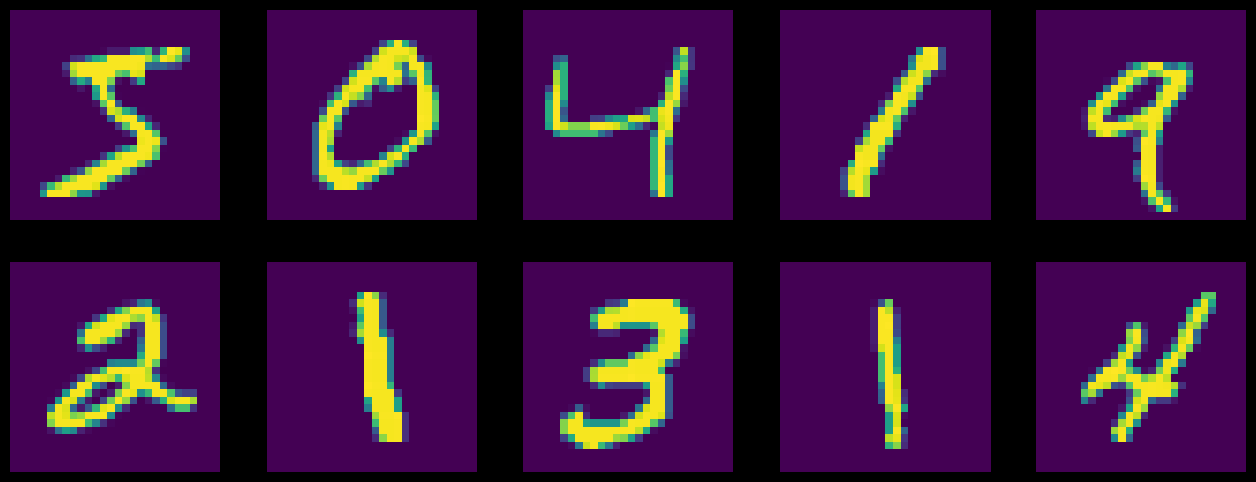

In [4]:
# show some images
to_pil = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    plt.imshow(to_pil(image))
    plt.axis('off')

In [5]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
t = torch.tensor([1.,2.])
s = torch.tensor([0.1,0.2])
t1 = torch.rand_like(t)
t1.mul(t), t1.mul(t).add_(s)

(tensor([0.0946, 0.6438]), tensor([0.1946, 0.8438]))

In [81]:
# Let's define our VAE

class VAE(nn.Module):
    def __init__(self, image_channels=1, hidden_size=64, latent_size=2):
        super(VAE, self).__init__()

        self.hidden_size = hidden_size
        self.latent_size = latent_size

        ## encoder ##
        self.Encoder = nn.Sequential(nn.Conv2d(image_channels, 16, 4, stride = 2, padding=1), #16x14x14   [(W−K+2P)/S]+1
                                        nn.ReLU(),
                                        nn.Conv2d(16, 32, 4, stride = 2, padding=1), #32x7x7
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, stride = 2, padding=1), #64x4x4
                                        nn.ReLU(),
                                        nn.Conv2d(64, self.hidden_size, 4, stride = 1, padding=0), #64x1x1
                                        nn.ReLU(),
                                        nn.Flatten())  #hidden_size


        # define mean
        self.encoder_mean = nn.Linear(self.hidden_size, self.latent_size)
        #define logvar
        self.encoder_logvar = nn.Linear(self.hidden_size, self.latent_size)

        self.resize_fc = nn.Linear(self.latent_size, self.hidden_size)

        ## decoder ##
        self.Decoder = nn.Sequential(nn.ConvTranspose2d( self.hidden_size, 64, 4, 1, 0), #4x4  (W - 1)S -2P + (K - 1) + 1
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 64, 32, 3, 2, 1), #7x7
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 32, 16, 4, 2, 1), #14x14
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 16, 1, 4, 2, 1), #28x28
                                    nn.Sigmoid())

    def sample(self, log_var, mean):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean) # reparametrization trick

    def KL_loss(self, log_var, mean):
        return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    def forward(self, x):
        x = self.Encoder(x)
        log_var = self.encoder_logvar(x)
        mean = self.encoder_mean(x)

        z = self.sample(log_var, mean)

        x = self.resize_fc(z).view(z.size(0),self.hidden_size,1,1)

        x = self.Decoder(x)

        return x, log_var, mean

    def generate_img(self, z):
        x = self.resize_fc(z).view(z.size(0),self.hidden_size,1,1)
        return self.Decoder(x)


vae = VAE().to(device)
print(vae)

VAE(
  (Encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder_mean): Linear(in_features=64, out_features=2, bias=True)
  (encoder_logvar): Linear(in_features=64, out_features=2, bias=True)
  (resize_fc): Linear(in_features=2, out_features=64, bias=True)
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2)

In [49]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

summary(model=vae,
        input_size=(10, 1, 28, 28), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VAE (VAE)                                [10, 1, 28, 28]      [10, 1, 28, 28]      --                   True
├─Sequential (Encoder)                   [10, 1, 28, 28]      [10, 64]             --                   True
│    └─Conv2d (0)                        [10, 1, 28, 28]      [10, 16, 14, 14]     272                  True
│    └─ReLU (1)                          [10, 16, 14, 14]     [10, 16, 14, 14]     --                   --
│    └─Conv2d (2)                        [10, 16, 14, 14]     [10, 32, 7, 7]       8,224                True
│    └─ReLU (3)                          [10, 32, 7, 7]       [10, 32, 7, 7]       --                   --
│    └─Conv2d (4)                        [10, 32, 7, 7]       [10, 64, 4, 4]       18,496               True
│    └─ReLU (5)                          [10, 64, 4, 4]       [10, 64, 4, 4]       --                   --
│    └─Conv2d (6)   

In [50]:
# define Optimizer and Loss
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# as loss lets use BCE (Binary Cross Entropy)
bce_loss = nn.BCELoss(reduction="sum")

In [82]:
# TRAIN!!!

PATH = "./res/vae.pth"

vae.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data = data.to(device)

        optimizer.zero_grad()
        output, log_var, mean = vae(data)

        bce = bce_loss(output, data)
        kl = vae.KL_loss(log_var, mean)
        loss = bce + kl
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE: {:.2f} KL: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), bce.item(), kl.item()))

    # save model every epoch
    #torch.save(vae.state_dict(), PATH)

Train Epoch: 0 [0/60000 (0%)]	BCE: 38023.12 KL: 0.75
Train Epoch: 0 [12800/60000 (21%)]	BCE: 38085.51 KL: 0.75
Train Epoch: 0 [25600/60000 (43%)]	BCE: 38107.38 KL: 0.75
Train Epoch: 0 [38400/60000 (64%)]	BCE: 38047.56 KL: 0.75
Train Epoch: 0 [51200/60000 (85%)]	BCE: 38019.43 KL: 0.76
Train Epoch: 1 [0/60000 (0%)]	BCE: 38146.80 KL: 0.76
Train Epoch: 1 [12800/60000 (21%)]	BCE: 38057.75 KL: 0.75
Train Epoch: 1 [25600/60000 (43%)]	BCE: 38143.43 KL: 0.76
Train Epoch: 1 [38400/60000 (64%)]	BCE: 38135.93 KL: 0.75
Train Epoch: 1 [51200/60000 (85%)]	BCE: 38093.55 KL: 0.76
Train Epoch: 2 [0/60000 (0%)]	BCE: 38057.12 KL: 0.75
Train Epoch: 2 [12800/60000 (21%)]	BCE: 37972.46 KL: 0.75
Train Epoch: 2 [25600/60000 (43%)]	BCE: 38090.37 KL: 0.75
Train Epoch: 2 [38400/60000 (64%)]	BCE: 38160.56 KL: 0.76
Train Epoch: 2 [51200/60000 (85%)]	BCE: 38135.97 KL: 0.76
Train Epoch: 3 [0/60000 (0%)]	BCE: 38069.02 KL: 0.77
Train Epoch: 3 [12800/60000 (21%)]	BCE: 37980.70 KL: 0.76
Train Epoch: 3 [25600/60000 (43%)]

In [ ]:
#Load a set of weights
vae.load_state_dict(torch.load(PATH))

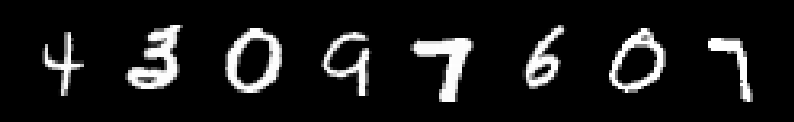

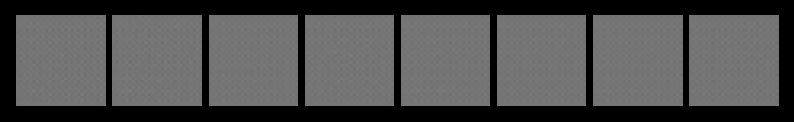

In [75]:
# TEST
image, target = next(iter(test_loader)) # load one batch
image = image.to(device)
i = 10
vae.eval()

out, _, _ = vae(image)

# input
plt.figure()
image_grid = torchvision.utils.make_grid(image[10:18])
plt.imshow(to_pil(image_grid))
plt.axis("off")
plt.show()

# output
plt.figure()
out_grid = torchvision.utils.make_grid(out[10:18])
plt.imshow(to_pil(out_grid))
plt.axis("off")
plt.show()

torch.Size([8, 2])


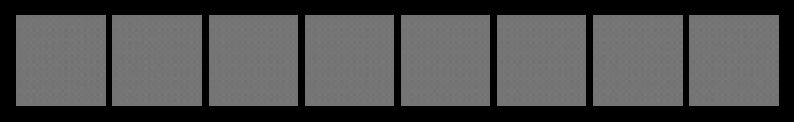

In [77]:
# GENERATE!!!!
z = torch.randn(8,2).to(device)
print(z.size())

generated_samples = vae.generate_img(z)

plt.figure()
gen_grid = torchvision.utils.make_grid(generated_samples)
plt.imshow(to_pil(gen_grid))
plt.axis("off")
plt.show()


NameError: name 'latent' is not defined

In [79]:
# Let's visualize latent space
image, target = next(iter(test_loader)) # load one batch
image = image.to(device)

_, log_var, mean = vae(image)

# sample noise in the latent space
z = vae.sample(log_var, mean)

z = z.cpu().detach().numpy()

In [78]:
# Let's visualize latent space
image, target = next(iter(test_loader)) # load one batch
image = image.to(device)

_, log_var, mean = vae(image)

# sample noise in the latent space
z = vae.sample(log_var, mean)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(z.detach().cpu().numpy())

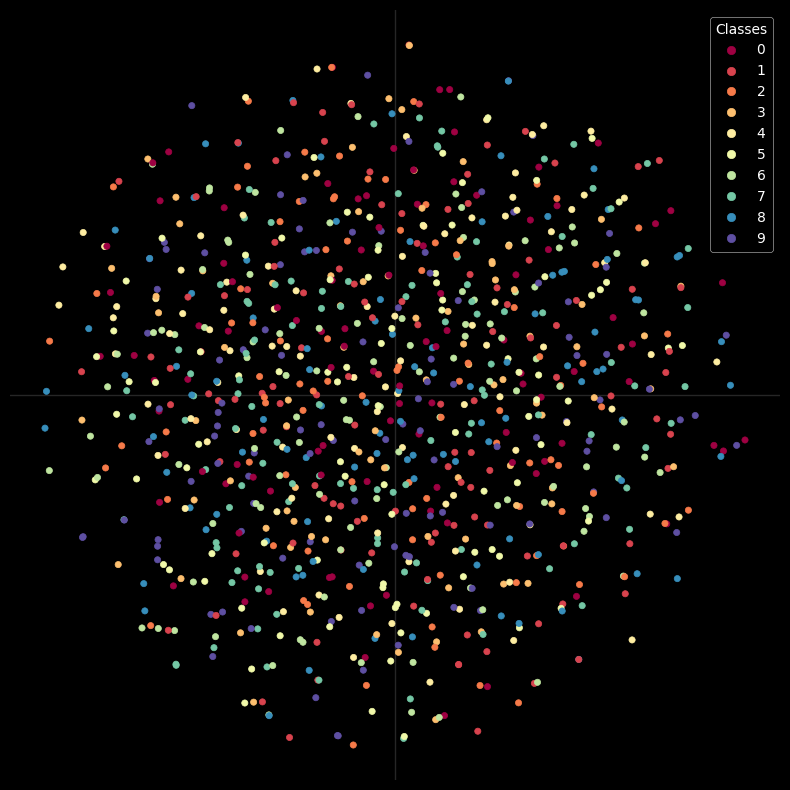

In [71]:

# scale and move the coordinates so they fit [-1; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [-1; 1] by dividing by its range
    return 2*(starts_from_zero / value_range) - 1

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

tsne[:, 0] = tx
tsne[:, 1] = ty

plot_data_np(tsne, target.numpy(), legend = True)

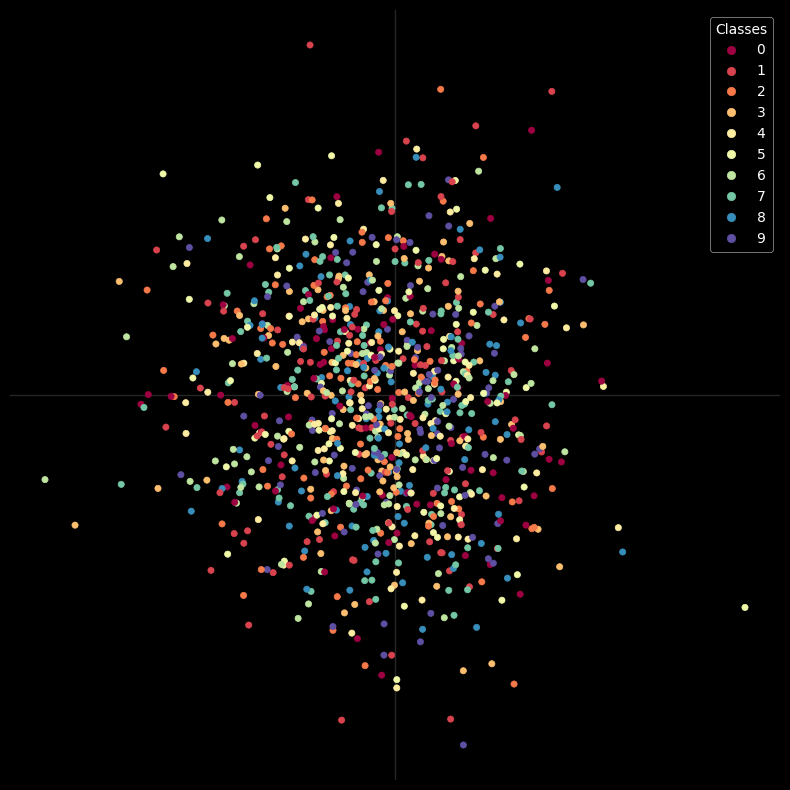

In [80]:
# plot
# scale and move the coordinates so they fit [-1; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [-1; 1] by dividing by its range
    return 2*(starts_from_zero / value_range) - 1

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = z[:, 0]
ty = z[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

z[:, 0] = tx
z[:, 1] = ty

plot_data_np(z, target.numpy(), legend = True)

In [46]:
# function to plot interpolation of generated sample
def plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = vae.generate_img(z)
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat.cpu().detach().numpy()
    plt.imshow(img, extent=[*r0, *r1])
    plt.axis('off')

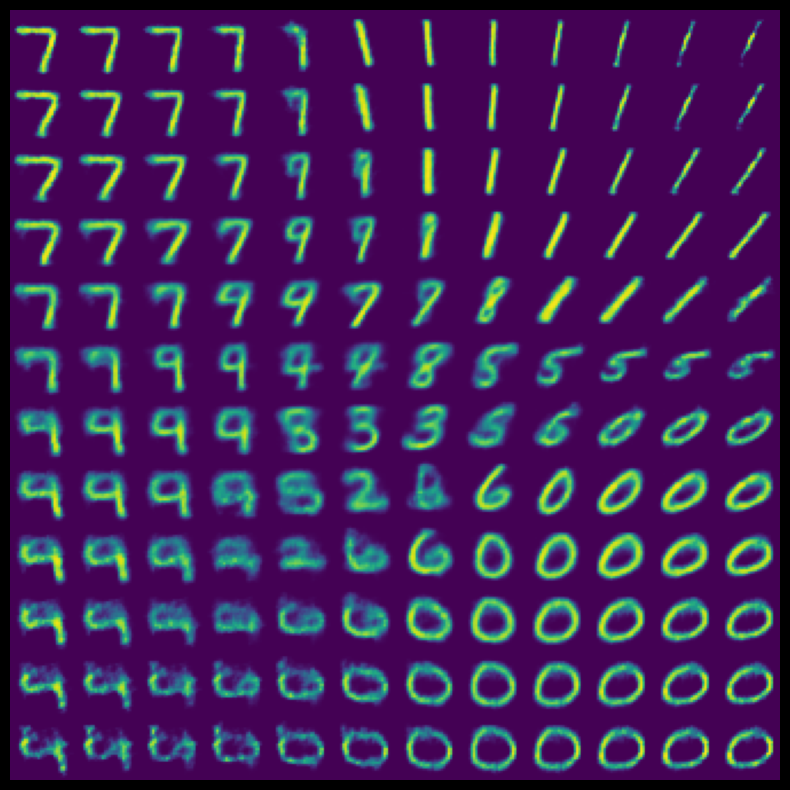

In [47]:
plot_reconstructed(vae)

In [ ]:
# Ex1: train the VAE incrementing the latent space, removing the reparametrization trick, changing the weights of the KL loss (e.g. 10*kl)

In [ ]:
# Ex2: train the VAE on Cifar10 (latent space of dim 2 is enough?)